In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb; sb.set()

K-Means algorithm is a simple example of **Expectation-Maximisation** Algorithm  
### Expectation-Maximisation Algorithm
> E-step: Update our expectation of which cluster each point belongs to  
> M-step: Maximise the fitness function to locate the cluster centers.  
Under typical circumstances, each repetition of E and M-step *always* results in a better estimate of cluster characteristics  
  
### Caveats of E-M Algorithm: *Solution*
1. Globally optimal results may not be achieved: *Run multiple guesses with `n_init`*
2. Number of clusters must be guessed: 
    - *Silhouette analysis to evaluate the results*
    - *Quantitatively measure the fitness per number of clusters: Gaussian mixture models*
    - *Choose the best number of clusters itself: DBSCAN, mean-shift, affinity propagation*
3. k-means is limited to linear cluster boundaries: *Represent data in higher-dimensions and use k-means. Spectral Clustering uses the graph of nearest neighbours to compute a higher-dimensional representation of the data, and then assigns the labels using k-means algorithm*
4. Slow for large numbers of samples: *use batch-based k-means algorithm*

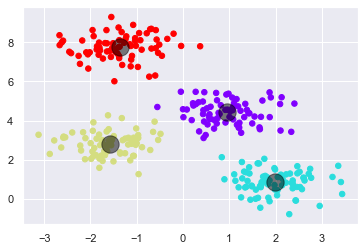

In [11]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

X, y = make_blobs(n_samples = 300, centers = 4, cluster_std = 0.60, random_state = 0)
plt.scatter(X[:, 0], X[:, 1], c = y, s = 30, cmap = 'rainbow')
model = KMeans(n_clusters = 4).fit(X)
y_pred = model.predict(X)
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], s = 300, alpha = 0.5, color = 'black')

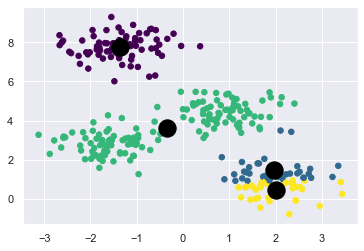

In [20]:
#Simple function to find cluster centers
from sklearn.metrics import pairwise_distances_argmin
def find_clusters(X, n_clusters, rseed = 2):
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        labels = pairwise_distances_argmin(X, centers)     #Assign labels for each point
        new_centers = np.array([X[labels == i].mean(0) for i in range(n_clusters)])     #Find new centers
        if np.all(centers == new_centers): #Check for convergence
            break
        centers = new_centers
    return centers, labels
centers, labels = find_clusters(X, 4, rseed = 0)  #Different initial guesses may have poor results: rseed = 0
plt.scatter(X[:, 0], X[:, 1], c = labels, s = 30, cmap = 'viridis')
plt.scatter(centers[:, 0], centers[:, 1], s = 300, color = 'black')

C:\Users\Oong\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


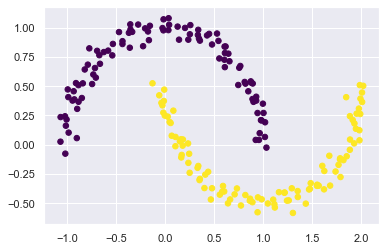

In [24]:
#Spectral Clustering
#Kernelized k-means is able to the more complicated non-linear boundaries between clusters
from sklearn.datasets import make_moons
from sklearn.cluster import SpectralClustering
X, y = make_moons(200, noise = 0.05, random_state = 0)
model = SpectralClustering(n_clusters = 2, affinity = 'nearest_neighbors', assign_labels = 'kmeans')
labels = model.fit_predict(X)
plt.scatter(X[:, 0], X[:, 1], c = labels, s = 30, cmap = 'viridis')

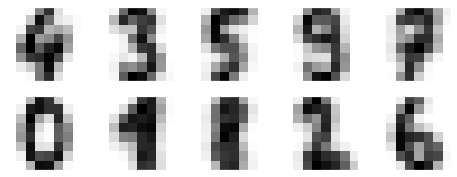

In [31]:
# k-means on digits
# Identify similar digits without using the original label information
from sklearn.datasets import load_digits
from sklearn.cluster import KMeans
digits = load_digits()
kmeans = KMeans(n_clusters = 10, random_state = 0)
clusters = kmeans.fit_predict(digits.data)

f, axes = plt.subplots(2, 5, figsize = (8, 3))
centers = kmeans.cluster_centers_.reshape(10, 8, 8)
for ax, center in zip(axes.flat, centers):
    ax.imshow(center, cmap = 'binary', interpolation = 'nearest')
    ax.set(xticks = [], yticks = [])

0.7935447968836951


(10.0, 0.0)

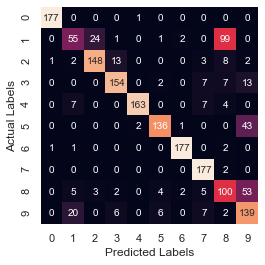

In [36]:
from scipy.stats import mode
from sklearn.metrics import accuracy_score, confusion_matrix
labels = np.zeros_like(clusters)
for i in range(10):
    mask = (clusters == i)
    labels[mask] = mode(digits.target[mask])[0]
print(accuracy_score(digits.target, labels))

mat = confusion_matrix(digits.target, labels)
ax = sb.heatmap(mat, cbar = None, annot = True, fmt = 'd', xticklabels = digits.target_names, 
           yticklabels = digits.target_names, square = True)
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')
ax.set_ylim(np.array(ax.get_ylim()) + (0.5, -0.5))

(427, 640, 3)


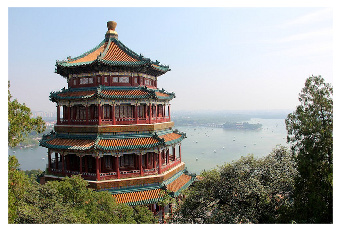

In [42]:
# Colour Compression
from sklearn.datasets import load_sample_image
china = load_sample_image('china.jpg')
ax = plt.axes(xticks = [], yticks = [])
ax.imshow(china)
print(china.shape)

In [46]:
#Prepare Data
data = china.reshape(427 * 640, 3)
data = data / 255.0
data.shape

(273280, 3)

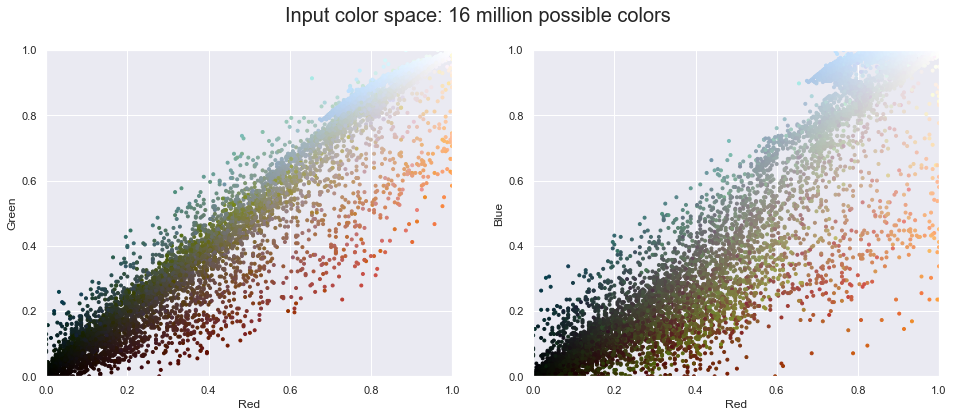

In [52]:
def plot_pixels(data, title, colors = None, N = 10000):
    if colors is None:
        colors = data
    rng = np.random.RandomState(0)
    i = rng.permutation(data.shape[0])[:N]
    colors = colors[i]
    R, G, B = data[i].T
    
    f, axes = plt.subplots(1, 2, figsize = (16, 6))
    f.suptitle(title, size = 20)
    axes[0].scatter(R, G, marker = '.', color = colors)
    axes[0].set(xlabel = 'Red', ylabel = 'Green', xlim = (0, 1), ylim = (0, 1))
    axes[1].scatter(R, B, marker = '.', color = colors)
    axes[1].set(xlabel = 'Red', ylabel = 'Blue', xlim = (0, 1), ylim = (0, 1))
plot_pixels(data, 'Input color space: 16 million possible colors')

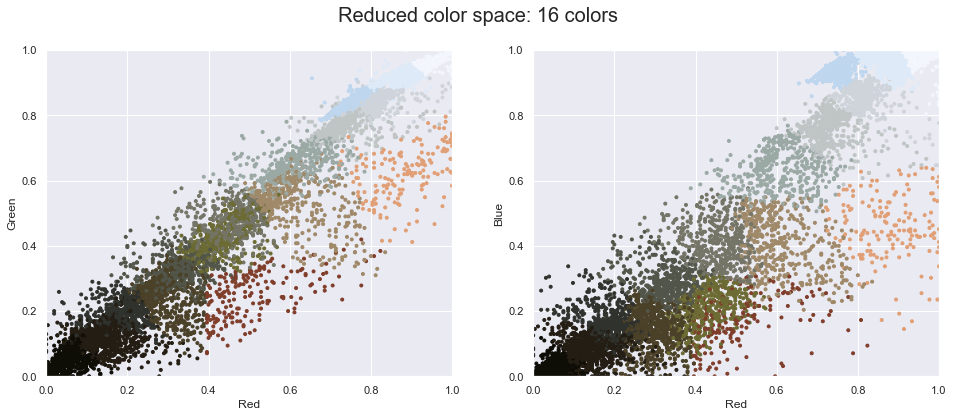

In [53]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(16)
kmeans.fit(data)
new_colors = kmeans.cluster_centers_[kmeans.predict(data)]
plot_pixels(data, 'Reduced color space: 16 colors', colors = new_colors)

Text(0.5, 1.0, 'Reduced image')

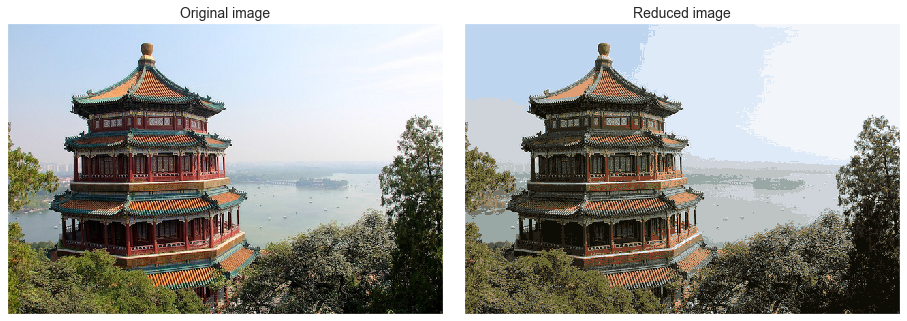

In [60]:
colored_china = new_colors.reshape(427, 640, 3)
f, axes = plt.subplots(1, 2, figsize = (16, 6), subplot_kw = dict(xticks = [], yticks = []))
f.subplots_adjust(wspace = 0.05)
axes[0].imshow(china)
axes[0].set_title('Original image', size = 14)
axes[1].imshow(colored_china)
axes[1].set_title('Reduced image', size = 14)